In [16]:
import pandas as pd
import os
import numpy as np
from pareto_generator import generate_pareto

In [17]:
path_solutions = 'solutions/'

solution_df_list = []
resultados_agrupados_dict = dict()
for idx, sol in enumerate(os.listdir(path_solutions)):
    path_sol = path_solutions + sol + '/'
    
    sol_df = pd.read_csv(path_sol + 'solution.csv')
    sol_df['solution'] = idx
    solution_df_list.append(sol_df)

    resultado_agrupado = pd.read_csv(path_sol + 'resultado_agrupado.csv')
    resultados_agrupados_dict[idx] = resultado_agrupado

solution_df = pd.concat(solution_df_list).reset_index(drop=True)
solution_df.head(3)

,Fobj,Result,solution
0,Obj1,-86395.6342,0
1,Obj2,6339.9000,0
2,Obj1,-108193.7535,1


In [18]:
df_pivot = (
    solution_df
    .pivot(index='solution', columns='Fobj', values='Result')
    .rename(columns={'Obj1': 'priority', 'Obj2': 'cost'})
    .reset_index()
    .sort_values(by='cost')
    # .drop(columns=['Fobj'])
)
solutions_drop = pd.Series([24, 28, 13, 7, 6, 3, 16, 11, 2, 18])
df_pivot_new = df_pivot[~df_pivot['solution'].isin(solutions_drop)]

Hipervolume : 13775559933.065475
Delta_metric: 0.4981268526496338 


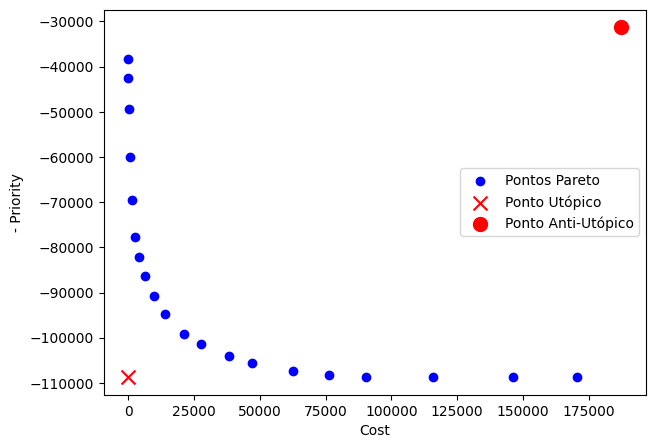

In [19]:
df_pivot = df_pivot_new
generate_pareto(df_pivot_new)

In [20]:
# Calculo de parametros de interesse a partir das soluções de cada ponto
for idx, key_df in resultados_agrupados_dict.items():
    avg_obras_por_deposito = resultados_agrupados_dict[idx]['OBRAS_EXECUTADAS'].mean()
    avg_priority_por_deposito = resultados_agrupados_dict[idx]['SOMA_PRIORIDADES_EXECUTADAS'].mean()
    
    # Desvio da media de obras executadas
    resultados_agrupados_dict[idx]['OBRAS DESVIO_MEDIA'] = abs(resultados_agrupados_dict[idx]['OBRAS_EXECUTADAS'] - avg_obras_por_deposito)
    resultados_agrupados_dict[idx]['OBRAS DESVIO_MEDIA_POW_2'] = np.power(resultados_agrupados_dict[idx]['OBRAS DESVIO_MEDIA'], 2)

    # Desvio da media de prioridade
    resultados_agrupados_dict[idx]['PRIORIDADE DESVIO_MEDIA'] = abs(resultados_agrupados_dict[idx]['SOMA_PRIORIDADES_EXECUTADAS'] - avg_priority_por_deposito)
    resultados_agrupados_dict[idx]['PRIORIDADE DESVIO_MEDIA_POW_2'] = np.power(resultados_agrupados_dict[idx]['PRIORIDADE DESVIO_MEDIA'], 2)

    # # Prioridade media por obra
    # resultados_agrupados_dict[idx]['PRIORIDADE_POR_OBRA'] = resultados_agrupados_dict[idx]['SOMA_PRIORIDADES_EXECUTADAS'] / resultados_agrupados_dict[idx]['OBRAS_EXECUTADAS']
    # resultados_agrupados_dict[idx]['PRIORIDADE_POR_OBRA_POW_2'] = np.power(resultados_agrupados_dict[idx]['PRIORIDADE_POR_OBRA'], 2)

    

In [21]:
resultados_agrupados_dict[5]

,cod_dep,NUM_OBRAS_ASSOCIADAS,OBRAS_EXECUTADAS,SOMA_PRIORIDADES_EXECUTADAS,SOMA_PRIORIDADES_ASSOCIADAS,OBRAS DESVIO_MEDIA,OBRAS DESVIO_MEDIA_POW_2,PRIORIDADE DESVIO_MEDIA,PRIORIDADE DESVIO_MEDIA_POW_2
0,3113,476,228.0,14381.2484,24038.0,60.5,3660.25,3975.35227,1.580343e+07
1,3182,264,139.0,9280.1256,13332.0,28.5,812.25,1125.77053,1.267359e+06
2,3256,667,470.0,28928.7839,33683.5,302.5,91506.25,18522.88777,3.430974e+08
3,3257,346,271.0,15917.3040,17473.0,103.5,10712.25,5511.40787,3.037562e+07
4,3273,211,144.0,8879.5712,10655.5,23.5,552.25,1526.32493,2.329668e+06
5,3285,181,110.0,6880.5000,9140.5,57.5,3306.25,3525.39613,1.242842e+07
6,3286,170,115.0,7193.2065,8585.0,52.5,2756.25,3212.68963,1.032137e+07
7,3294,160,94.0,6000.3773,8080.0,73.5,5402.25,4405.51883,1.940860e+07
8,3326,153,93.0,5847.3749,7726.5,74.5,5550.25,4558.52123,2.078012e+07
9,6300,197,11.0,750.4695,9948.5,156.5,24492.25,9655.42663,9.322726e+07


RMAD - Root Mean Squared Deviation

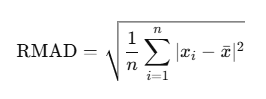

In [22]:
df_pivot['Obras Executadas'] = df_pivot.apply(lambda x: resultados_agrupados_dict[x['solution']]['OBRAS_EXECUTADAS'].sum(), axis=1)

# Desvio num de obras por deposito
df_pivot['RMSD obras por deposito'] = df_pivot.apply(lambda x: np.sqrt(resultados_agrupados_dict[x['solution']]['OBRAS DESVIO_MEDIA_POW_2'].mean()), axis=1)

# Desvio prioridade por deposito
df_pivot['RMSD prioridade por deposito'] = df_pivot.apply(lambda x: np.sqrt(resultados_agrupados_dict[x['solution']]['PRIORIDADE DESVIO_MEDIA_POW_2'].mean()), axis=1)


In [23]:
decision_matrix = df_pivot[['priority', 'cost', 'RMSD obras por deposito', 'RMSD prioridade por deposito']].reset_index(drop=True)
decision_matrix

Fobj,priority,cost,RMSD obras por deposito,RMSD prioridade por deposito
0,-38331.9794,0.00,66.210347,4113.252889
1,-42449.9088,42.52,69.186704,4442.650045
2,-49306.5796,185.27,78.746492,5085.041408
3,-60070.1861,611.41,93.371784,6066.951861
4,-69631.0370,1411.30,100.233926,6584.517993
5,-77783.8657,2720.14,107.120540,6852.877634
6,-82099.0171,4101.49,108.693192,6868.393673
7,-86395.6342,6339.90,108.458517,6856.700360
8,-90770.2748,9680.97,109.980907,6879.019262
9,-94725.5268,13805.42,114.453003,7060.928842


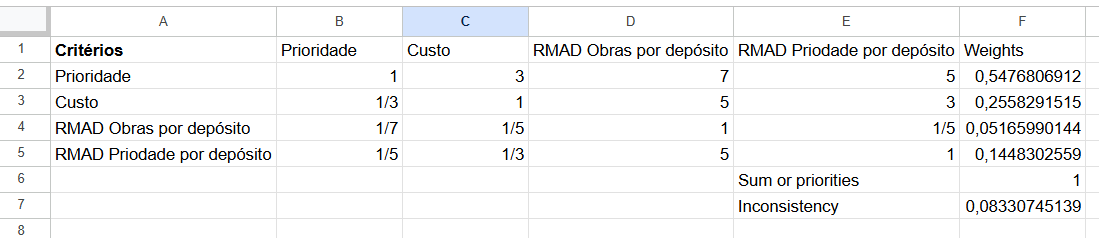

In [24]:
# Weights got from excel 
w_priority = 0.5476806912
w_cost = 0.2558291515
w_obras_por_deposito = 0.05165990144
w_priority_por_deposito = 0.1448302559

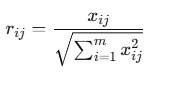

In [25]:
decision_matrix

Fobj,priority,cost,RMSD obras por deposito,RMSD prioridade por deposito
0,-38331.9794,0.00,66.210347,4113.252889
1,-42449.9088,42.52,69.186704,4442.650045
2,-49306.5796,185.27,78.746492,5085.041408
3,-60070.1861,611.41,93.371784,6066.951861
4,-69631.0370,1411.30,100.233926,6584.517993
5,-77783.8657,2720.14,107.120540,6852.877634
6,-82099.0171,4101.49,108.693192,6868.393673
7,-86395.6342,6339.90,108.458517,6856.700360
8,-90770.2748,9680.97,109.980907,6879.019262
9,-94725.5268,13805.42,114.453003,7060.928842


In [26]:
# Normalize matrix
priority_squared_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['priority']]))
cost_squared_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['cost']]))
RMSD_obra_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['RMSD obras por deposito']]))
RMSD_priority_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['RMSD prioridade por deposito']]))

normalized_matrix = decision_matrix.copy()
normalized_matrix['priority'] = normalized_matrix['priority'] / priority_squared_factor
normalized_matrix['cost'] = normalized_matrix['cost'] / cost_squared_factor
normalized_matrix['RMSD obras por deposito'] = normalized_matrix['RMSD obras por deposito'] / RMSD_obra_factor
normalized_matrix['RMSD prioridade por deposito'] = normalized_matrix['RMSD prioridade por deposito'] / RMSD_priority_factor
normalized_matrix.head(3)


Fobj,priority,cost,RMSD obras por deposito,RMSD prioridade por deposito
0,-0.094595,0.000000,0.132884,0.133255
1,-0.104758,0.000144,0.138857,0.143926
2,-0.121678,0.000628,0.158044,0.164737


In [27]:
# Apply weights
weighted_matrix = normalized_matrix.copy()
weighted_matrix['priority'] = weighted_matrix['priority'] * w_priority
weighted_matrix['cost'] = weighted_matrix['cost'] * w_cost
weighted_matrix['RMSD obras por deposito'] = weighted_matrix['RMSD obras por deposito'] * w_obras_por_deposito
weighted_matrix['RMSD prioridade por deposito'] = weighted_matrix['RMSD prioridade por deposito'] * w_priority_por_deposito
weighted_matrix.head(3)

Fobj,priority,cost,RMSD obras por deposito,RMSD prioridade por deposito
0,-0.051808,0.000000,0.006865,0.019299
1,-0.057374,0.000037,0.007173,0.020845
2,-0.066641,0.000161,0.008165,0.023859


In [28]:
# Store best and worst decisions
priority_best_decision = weighted_matrix['priority'].min()
cost_best_decision = weighted_matrix['cost'].min()
rmsd_obras_best_decision = weighted_matrix['RMSD obras por deposito'].min()
rmsd_priority_best_decision = weighted_matrix['RMSD prioridade por deposito'].min()

priority_worst_decision = weighted_matrix['priority'].max()
cost_worst_decision = weighted_matrix['cost'].max()
rmsd_obras_worst_decision = weighted_matrix['RMSD obras por deposito'].max()
rmsd_priority_worst_decision = weighted_matrix['RMSD prioridade por deposito'].max()

# Function to calculate distance of a given solution
def calculate_euclidian_distance_best_decision(priority, cost, rmsd_obras, rmsd_priority):
    
    power_priority = np.power(priority - priority_best_decision, 2)
    power_cost = np.power(cost - cost_best_decision, 2)
    power_rmsd_obras = np.power(rmsd_obras - rmsd_obras_best_decision, 2)
    power_rmsd_priority = np.power(rmsd_priority - rmsd_priority_best_decision, 2)

    result = np.sqrt( 
        power_priority + 
        power_cost + 
        power_rmsd_obras + 
        power_rmsd_priority
    )
    return result

# Function to calculate distance of a given solution
def calculate_euclidian_distance_worst_decision(priority, cost, rmsd_obras, rmsd_priority):
    
    power_priority = np.power(priority - priority_worst_decision, 2)
    power_cost = np.power(cost - cost_worst_decision, 2)
    power_rmsd_obras = np.power(rmsd_obras - rmsd_obras_worst_decision, 2)
    power_rmsd_priority = np.power(rmsd_priority - rmsd_priority_worst_decision, 2)

    result = np.sqrt( 
        power_priority + 
        power_cost + 
        power_rmsd_obras + 
        power_rmsd_priority
    )
    return result


# Calculate distance of each solution to best and worst decisions
weighted_matrix['S+'] = weighted_matrix.apply(
    lambda x: calculate_euclidian_distance_best_decision(
        priority=x['priority'], 
        cost=x['cost'],
        rmsd_obras=x['RMSD obras por deposito'],
        rmsd_priority=x['RMSD prioridade por deposito']
    ), axis=1
)
weighted_matrix['S-'] = weighted_matrix.apply(
    lambda x: calculate_euclidian_distance_worst_decision(
        priority=x['priority'], 
        cost=x['cost'],
        rmsd_obras=x['RMSD obras por deposito'],
        rmsd_priority=x['RMSD prioridade por deposito']
    ), axis=1
)

# Calculate P and define rank of decisions
weighted_matrix['P'] = weighted_matrix['S-'] / (weighted_matrix['S+'] + weighted_matrix['S-'])
weighted_matrix['Rank'] = weighted_matrix['P'].rank(ascending=False)
weighted_matrix

Fobj,priority,cost,RMSD obras por deposito,RMSD prioridade por deposito,S+,S-,P,Rank
0,-0.051808,0.000000,0.006865,0.019299,0.095165,0.148986,0.610221,16.0
1,-0.057374,0.000037,0.007173,0.020845,0.089614,0.148874,0.624243,15.0
2,-0.066641,0.000161,0.008165,0.023859,0.080472,0.149070,0.649423,13.0
3,-0.081189,0.000531,0.009681,0.028466,0.066482,0.150503,0.693610,12.0
4,-0.094111,0.001225,0.010392,0.030894,0.054248,0.152767,0.737950,10.0
5,-0.105130,0.002361,0.011106,0.032154,0.044042,0.155062,0.778800,8.0
6,-0.110962,0.003560,0.011269,0.032226,0.038678,0.156050,0.801373,6.0
7,-0.116769,0.005502,0.011245,0.032172,0.033578,0.156575,0.823418,5.0
8,-0.122682,0.008402,0.011403,0.032276,0.029149,0.156525,0.843009,3.0
9,-0.128027,0.011981,0.011867,0.033130,0.026810,0.155864,0.853234,1.0


In [29]:
# Chosen decision
filter_decision = weighted_matrix['Rank'] == 1
best_decision = weighted_matrix[filter_decision].index[0]


pareto_best_decision = (
    decision_matrix[filter_decision]['priority'].iloc[0], 
    decision_matrix[filter_decision]['cost'].iloc[0], 
)
decision_matrix[filter_decision]


Fobj,priority,cost,RMSD obras por deposito,RMSD prioridade por deposito
9,-94725.5268,13805.42,114.453003,7060.928842


Hipervolume : 13775559933.065475
Delta_metric: 0.4981268526496338 


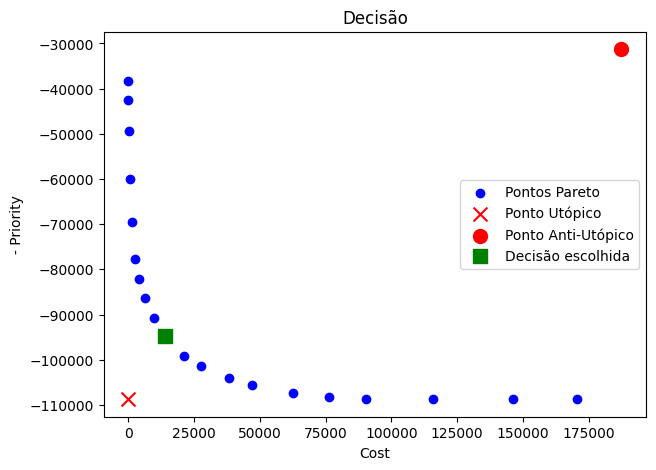

In [30]:
generate_pareto(decision_matrix, title='Decisão', decision=pareto_best_decision)